In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
import math
from astropy.constants import R
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import seaborn as sns

In [21]:
# Choose before or after the MFI
aMFI = True  # after MFI
bMFI = False # before MFI

# Choose asteroid or comet
asteroid = False
comet = True

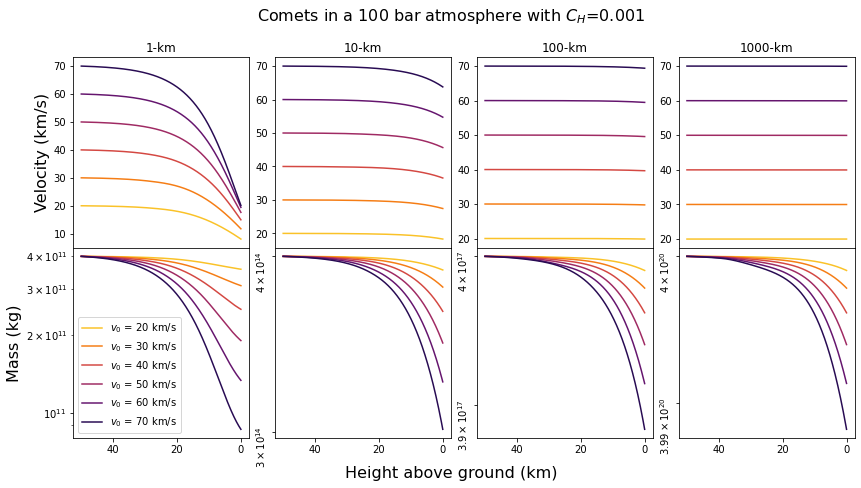

In [30]:
# We define our system of differential equations
def system(z, y, rho_function):
    # Setting the variables
    v, m = y
    
    # Some coefficients and parameters
    c_D = 0.92 # drag coefficient (Chyba, 1990; Zahnle & MacLow, 1994)
    c_H = 0.001 # heat transfer coefficient (Chyba, 1990)
    if asteroid == True:
        zeta = 3.2 * 1e6 # in J.kg-1 for carb chondrites (Chyba, 1990)
        rho_body = 1700
    if comet == True:
        zeta = 1.6 * 1e6 # in J.kg-1 for comets (Chyba, 1990)
        rho_body = 800
    R_z = np.cbrt(3 * m /(4 * np.pi * rho_body))
    rho_z = rho_function(z)
    g = 9.81    # in m.s-2
        
    # Equation of ablation: dv/dz and dm/dz
    dvdz = (3 * c_D * rho_z * v)/(8 * rho_body * R_z) - g*np.sin(np.pi/4.)/v
    dmdz = (c_H * rho_z * (v**2) * np.pi * R_z**2) / (2 * zeta)
    return [dvdz, dmdz]

# Initialize the density
def rho_function(z):
    if aMFI == True:
        T_surf = 500 # Surface temperature in K. (Zahnle et al 2007)  # In Warren et al (2019) they just assume an isothermal profil and take the surf. temp. as the mean temp.
        # T_z =  # We assume that the temp. is adiabatic above 150 K and isothermal below this threshold. => actually not necessary as ablation only depends of pressure
        p_0 = 1e7 # surface pressure in Pa # = 100 bars (Zahnle et al 2007)
    if bMFI == True:
        T_surf = 600
        p_0 = 3e7 # surface pressure in Pa # = 300 bars
    g = 9.81    # g in m.s-2
    R_CO2 = R.value * 1000 / 44  #44.01 # R in J.kg-1.K-1 or m2.s-2.K-1 with J = Pa.m3 and Pa = kg.m-1.s-2  # *1000 is to have kg instead of g
    H = R_CO2 * T_surf / g  # scale height in m
    rho_0 = p_0 / (R_CO2 * T_surf) # in kg.m-3
    p_z = p_0 * np.exp(-z/H)
    rho_z = rho_0 * np.exp(-z/H)
    return rho_z


# Altitude range
z_span = [50000, 0]


# Initial conditions
#v0 = 20000 # in m/s
v_list = [20000, 30000, 40000, 50000, 60000, 70000]
#colors = ["#F9C93F","#F47A15","#BE3952", "#751A6D","#1A0B41"]
colors = [(0.981173, 0.759135, 0.156863), (0.961293, 0.488716, 0.084289), (0.832299, 0.283913, 0.257383), (0.621685, 0.164184, 0.388781), (0.397674, 0.083257, 0.433183), (0.15585, 0.044559, 0.325338)]
#m0 = 1e21 # in kg
if comet == True:
    m_list = [4e11, 4e14, 4e17, 4e20]
if asteroid == True: 
    m_list = [8.5e11, 8.5e14, 8.5e17, 8.5e20]
    
fig, ax = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(14,7))
fig.suptitle('Comets in a 100 bar atmosphere with $C_H$=0.001', fontsize=16)
# We plot the results
ax[0][0].set_title('1-km')
ax[0][1].set_title('10-km')
ax[0][2].set_title('100-km')
ax[0][3].set_title('1000-km')
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.15)
ax[0][0].set_ylabel('Velocity (km/s)', fontsize=16)
ax[0][0].invert_xaxis()
fig.supxlabel('Height above ground (km)', x=0.5, y=0.04, fontsize=16)
ax[1][0].set_ylabel('Mass (kg)', fontsize=16)
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')
ax[1][2].set_yscale('log')
ax[1][3].set_yscale('log')

for m_count, m0 in enumerate(m_list):
    for count, v0 in enumerate(v_list):
        initial_conditions = [v0, m0]  # initial velocity and mass
    
        # Solve the system of differential equations
        solution = solve_ivp(system, z_span, initial_conditions, method='RK45', dense_output=True, args=(rho_function,))
    
        # Extract the solution for v and m
        z_values = np.linspace(z_span[0], z_span[1], 100000)
        sol = solution.sol(z_values)
    
        v_solution = sol[0]
        m_solution = sol[1]

        ax[0][m_count].plot(z_values/1000, v_solution/1000, label='$v_{0}$ = ' + str(int(v0/1000)) + ' km/s', c = colors[count])
        ax[1][m_count].plot(z_values/1000, m_solution, label='$v_{0}$ = ' + str(int(v0/1000)) + ' km/s', c = colors[count])

    ax[1][0].legend()
    
ax[1][1].tick_params('y', labelrotation=90)
#ax[1][1].set_yticks([1e15,1e13, 1e11, 1e9])
ax[1][1].set_yticks([4e14, 3e14])
#ax[1][1].set_yticks([4e14, 1e14, 1e12, 1e10, 1e8, 1e6])
#ax[1][1].set_yticks([8.5e14, 6.5e14, 4.5e14])
ax[1][1].set_yticks([], minor=True)
ax[1][2].tick_params('y', labelrotation=90)
#ax[1][2].set_yticks([1e18, 9e17, 8e17, 7e17])
ax[1][2].set_yticks([4e17, 3.9e17])
#ax[1][2].set_yticks([4e20, 3.95e20, 3.9e20])
#ax[1][2].set_yticks([4e17, 3e17, 2e17, 1e17])
#ax[1][2].set_yticks([8.5e17, 8e17])
ax[1][2].set_yticks([], minor=True)
ax[1][3].tick_params('y', labelrotation=90)
ax[1][3].set_yticks([], minor=True)
#ax[1][3].set_yticks([1e21, 9.9e20, 9.7e20])
ax[1][3].set_yticks([4e20, 3.99e20])
#ax[1][3].set_yticks([4e20, 3.99e20, 3.98e20])
#ax[1][3].set_yticks([4e20, 3.9e20, 3.8e20])
#ax[1][3].set_yticks([8.5e20, 8.45e20])

fig.savefig('/Users/sarahjoiret/Desktop/sims/bristol/comets_100bar_cH.pdf', dpi=200, bbox_inches='tight')

In [116]:
#print(rho_function(z_values))
R_z = np.cbrt(3 * m_solution /(4 * np.pi * 2000))
#print(R_z)
print(m_solution)

[1.00000000e+18 9.99999992e+17 9.99999983e+17 ... 9.85821527e+17
 9.85820914e+17 9.85820302e+17]


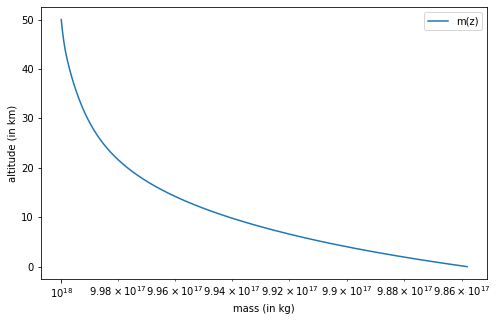

In [117]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(m_solution, z_values/1000, label='m(z)')
ax.set_xlabel('mass (in kg)')
ax.set_ylabel('altitude (in km)')
ax.set_xscale('log')
ax.invert_xaxis()
plt.legend()
plt.show()

In [187]:
print(sns.color_palette("inferno_r"))

[(0.981173, 0.759135, 0.156863), (0.961293, 0.488716, 0.084289), (0.832299, 0.283913, 0.257383), (0.621685, 0.164184, 0.388781), (0.397674, 0.083257, 0.433183), (0.15585, 0.044559, 0.325338)]


In [15]:
z = np.linspace(0,80000)
if aMFI == True:
    T_surf = 500 # Surface temperature in K. (Zahnle et al 2007)  # In Warren et al (2019) they just assume an isothermal profil and take the surf. temp. as the mean temp.
    #T_z =  # We assume that the temp. is adiabatic above 150 K and isothermal below this threshold. => actually not necessary as ablation only depends of pressure
    p_0 = 1.0e7 # surface pressure in Pa # = 100 bars (Zahnle et al 2007)
if bMFI == True:
    T_surf = 600
    p_0 = 3e7 # surface pressure in Pa # = 300 bars
bMFI = True
aMFI = False
g = 9.81    # g in m.s-2
R_CO2 = R.value * 1000 / 44.01  #44.01 # R in J.kg-1.K-1 or m2.s-2.K-1 with J = Pa.m3 and Pa = kg.m-1.s-2  # *1000 is to have kg instead of g
R_N2 = R.value * 1000 / 28.0
H = R_CO2 * T_surf / g  # scale height in m
H_N2 = R_N2 * T_surf / g  # scale height in m
rho_0 = p_0 / (R_CO2 * T_surf) # in kg.m-3
rho_0_N2 = p_0 / (R_N2 * T_surf) # in kg.m-3
p_z = p_0 * np.exp(-z/H)
p_z_N2 = p_0 * np.exp(-z/H_N2)
#rho_z = rho_0 * np.exp(-z/H)
#print(R_CO2)
#print(H)
#print(H_N2)
print(z)
print(p_z)
#print(p_z_N2)
#print(p_0)
#print(rho_0)

[    0.          1632.65306122  3265.30612245  4897.95918367
  6530.6122449   8163.26530612  9795.91836735 11428.57142857
 13061.2244898  14693.87755102 16326.53061224 17959.18367347
 19591.83673469 21224.48979592 22857.14285714 24489.79591837
 26122.44897959 27755.10204082 29387.75510204 31020.40816327
 32653.06122449 34285.71428571 35918.36734694 37551.02040816
 39183.67346939 40816.32653061 42448.97959184 44081.63265306
 45714.28571429 47346.93877551 48979.59183673 50612.24489796
 52244.89795918 53877.55102041 55510.20408163 57142.85714286
 58775.51020408 60408.16326531 62040.81632653 63673.46938776
 65306.12244898 66938.7755102  68571.42857143 70204.08163265
 71836.73469388 73469.3877551  75102.04081633 76734.69387755
 78367.34693878 80000.        ]
[3.00000000e+07 2.60469770e+07 2.26148336e+07 1.96349350e+07
 1.70476900e+07 1.48013596e+07 1.28510224e+07 1.11576761e+07
 9.68745778e+06 8.41096632e+06 7.30267486e+06 6.34042012e+06
 5.50495923e+06 4.77958487e+06 4.14979123e+06 3.60298